## Scraping Best Books from Amazon website

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

In [6]:
no_pages = 2

def get_data(pageNo):  
    
    r = requests.get('https://www.amazon.in/gp/bestsellers/books/ref=zg_bs_pg_'+str(pageNo)+'?ie=UTF8&pg='+str(pageNo))#, proxies=proxies)
    content = r.content
    soup = BeautifulSoup(content)
    #print(soup)

    alls = []
    for d in soup.findAll('div', attrs={'class':'a-section a-spacing-none aok-relative'}):
        #print(d)
        name = d.find('span', attrs={'class':'zg-text-center-align'})
        n = name.find_all('img', alt=True)
        #print(n[0]['alt'])
        author = d.find('a', attrs={'class':'a-size-small a-link-child'})
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated = d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price = d.find('span', attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is not None:
            #print(n[0]['alt'])
            all1.append(n[0]['alt'])
        else:
            all1.append("unknown-product")

        if author is not None:
            #print(author.text)
            all1.append(author.text)
        elif author is None:
            author = d.find('span', attrs={'class':'a-size-small a-color-base'})
            if author is not None:
                all1.append(author.text)
            else:    
                all1.append('0')

        if rating is not None:
            #print(rating.text)
            all1.append(rating.text)
        else:
            all1.append('-1')

        if users_rated is not None:
            #print(price.text)
            all1.append(users_rated.text)
        else:
            all1.append('0')     

        if price is not None:
            #print(price.text)
            all1.append(price.text)
        else:
            all1.append('0')
        alls.append(all1)    
    return alls

In [7]:
results = []
for i in range(1, no_pages+1):
    results.append(get_data(i))
flatten = lambda l: [item for sublist in l for item in sublist]
df = pd.DataFrame(flatten(results),columns=['Book Name','Author','Rating','Customers_Rated', 'Price'])
df.to_csv('amazon_products.csv', index=False, encoding='utf-8')

In [8]:
df = pd.read_csv("amazon_products.csv")

In [9]:
df.shape

(100, 5)

In [21]:
df.head()

,Book Name,Author,Rating,Customers_Rated,Price
0,Ikigai: The Japanese secret to a long and happ...,Héctor García,4.6 out of 5 stars,"7,810",₹ 299.00
1,My First Library: Boxset of 10 Board Books for...,Wonder House Books,4.5 out of 5 stars,"12,626",₹ 399.00
2,Attitude Is Everything: Change Your Attitude ....,Jeff Keller,4.5 out of 5 stars,"5,486",₹ 135.00
3,Rich Dad Poor Dad: What the Rich Teach Their K...,Robert T. Kiyosaki,4.6 out of 5 stars,"35,294",₹ 214.00
4,Quantitative Aptitude for Competitive Examinat...,R S Aggarwal,4.4 out of 5 stars,"7,316",₹ 439.00


In [54]:
df.dtypes

Book Name           object
Author              object
Rating             float64
Customers_Rated      int64
Price                int32
dtype: object

In [22]:
df['Rating'] = df['Rating'].apply(lambda x: x.split()[0])

In [23]:
df['Rating'] = pd.to_numeric(df['Rating'])

In [24]:
df["Price"] = df["Price"].str.replace('₹', '')

In [25]:
df["Price"] = df["Price"].str.replace(',', '')

In [26]:
df['Price'] = df['Price'].apply(lambda x: x.split('.')[0])

In [27]:
df['Price'] = df['Price'].astype(int)

In [28]:
df["Customers_Rated"] = df["Customers_Rated"].str.replace(',', '')

In [29]:
df['Customers_Rated'] = pd.to_numeric(df['Customers_Rated'], errors='ignore')

In [30]:
df.head()

,Book Name,Author,Rating,Customers_Rated,Price
0,Ikigai: The Japanese secret to a long and happ...,Héctor García,4.6,7810,299
1,My First Library: Boxset of 10 Board Books for...,Wonder House Books,4.5,12626,399
2,Attitude Is Everything: Change Your Attitude ....,Jeff Keller,4.5,5486,135
3,Rich Dad Poor Dad: What the Rich Teach Their K...,Robert T. Kiyosaki,4.6,35294,214
4,Quantitative Aptitude for Competitive Examinat...,R S Aggarwal,4.4,7316,439


In [31]:
df.to_csv('amazon_products.csv', index=False, encoding='utf-8')

## Scraping Wikipedia page

In [32]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests

In [33]:
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [34]:
#main link
wiki_link = 'https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Literature'

In [35]:
page_content = session.get(wiki_link)

In [36]:
page_content_parser = BeautifulSoup(page_content.text, 'html.parser')

### Search for the necessary table

In [37]:
def find_laureates_tag(tag):
    return tag.has_attr('id') and tag['id'] == 'Laureates'

In [38]:
#Get the tag which belongs to the title of the section
laureates_tag = page_content_parser.find(find_laureates_tag)

In [39]:
laureates_tag

<span class="mw-headline" id="Laureates">Laureates</span>

In [40]:
tag = laureates_tag.parent

In [41]:
while tag.name != 'table':
    tag = tag.next_sibling

In [42]:
tag.name

'table'

### Scrap the table

In [43]:
def parse_the_row(cells, writer_info, same_year, mem_year):
    start_index = 0
    if same_year > 0:
        writer_info['year'].append(mem_year)
        same_year -= 1   
        start_index = 1
    elif cells[0].has_attr('rowspan'):
        same_year = int(cells[0]['rowspan']) - 1
        mem_year = cells[0].text
        writer_info['year'].append(mem_year)
    else:
        writer_info['year'].append(cells[0].text)
        
    if len(cells) == 2:
        writer_info['name'].append(cells[1].text)
        writer_info['link'].append(np.nan)
        writer_info['country'].append(np.nan)
        writer_info['language'].append(np.nan)
        writer_info['citation'].append(np.nan)
        writer_info['genres'].append(np.nan)
    else:
        writer_info['name'].append(cells[2 - start_index].text)
        writer_info['link'].append(cells[2 - start_index].a['href'])
        writer_info['country'].append(cells[3 - start_index].text)
        writer_info['language'].append(cells[4 - start_index].text)
        writer_info['citation'].append(cells[5 - start_index].text)
        writer_info['genres'].append(cells[6 - start_index].text)
    return same_year, mem_year

In [44]:
same_year = 0
mem_year = ""

In [45]:
writer_info = {
    'year' : [],
    'name' : [],
    'country' : [],
    'language' : [],
    'citation' : [],
    'genres' : [],
    'link' : []
}

In [46]:
nobel_table = tag.tbody.children

In [47]:
for row in nobel_table:
    if (row.name):
        cells = row.find_all('td')

        if len(cells) > 0:
            same_year, mem_year = parse_the_row(cells, writer_info, same_year, mem_year)

In [48]:
writers_table = pd.DataFrame(writer_info, columns = [x for x in writer_info])

In [56]:
writers_table.head()

,year,name,country,language,citation,genres,link
0,1901,Sully Prudhomme (1839 – 1907)\n,France\n,French\n,"""in special recognition of his poetic composit...","poetry, essay\n",/wiki/Sully_Prudhomme
1,1902,Theodor Mommsen (1817 – 1903)\n,Germany\n,German\n,"""the greatest living master of the art of hist...","history, law\n",/wiki/Theodor_Mommsen
2,1903,Bjørnstjerne Bjørnson (1832 – 1910)\n,Norway\n,Norwegian\n,"""as a tribute to his noble, magnificent and ve...","poetry, novel, drama\n",/wiki/Bj%C3%B8rnstjerne_Bj%C3%B8rnson
3,1904,Frédéric Mistral (1830 – 1914)\n,France\n,Provençal\n,"""in recognition of the fresh originality and t...","poetry, philology\n",/wiki/Fr%C3%A9d%C3%A9ric_Mistral
4,1904,José Echegaray (1830 – 1914)\n,Spain\n,Spanish\n,"""in recognition of the numerous and brilliant ...",drama\n,/wiki/Jos%C3%A9_Echegaray


In [53]:
writers_table.dtypes

year        object
name        object
country     object
language    object
citation    object
genres      object
link        object
dtype: object

In [55]:
writers_table['year'] = writers_table['year'].str.replace('\n', '')

In [57]:
writers_table['name'] = writers_table['name'].str.replace('\n', '')
writers_table['country'] = writers_table['country'].str.replace('\n', '')
writers_table['language'] = writers_table['language'].str.replace('\n', '')
writers_table['citation'] = writers_table['citation'].str.replace('\n', '')
writers_table['genres'] = writers_table['genres'].str.replace('\n', '')

In [62]:
writers_table.head()

,year,name,country,language,citation,genres,link
0,1901,Sully Prudhomme (1839 – 1907),France,French,"""in special recognition of his poetic composit...","poetry, essay",/wiki/Sully_Prudhomme
1,1902,Theodor Mommsen (1817 – 1903),Germany,German,"""the greatest living master of the art of hist...","history, law",/wiki/Theodor_Mommsen
2,1903,Bjørnstjerne Bjørnson (1832 – 1910),Norway,Norwegian,"""as a tribute to his noble, magnificent and ve...","poetry, novel, drama",/wiki/Bj%C3%B8rnstjerne_Bj%C3%B8rnson
3,1904,Frédéric Mistral (1830 – 1914),France,Provençal,"""in recognition of the fresh originality and t...","poetry, philology",/wiki/Fr%C3%A9d%C3%A9ric_Mistral
4,1904,José Echegaray (1830 – 1914),Spain,Spanish,"""in recognition of the numerous and brilliant ...",drama,/wiki/Jos%C3%A9_Echegaray


In [63]:
writers_table.to_csv('Wiki.csv', index=False, encoding='utf-8')

## Scraping data from Monster.com website

In [112]:
URL = 'https://www.monster.com/jobs/search/?q=Business-Analyst&where=india'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

### Find Elements by ID

In [113]:
results = soup.find(id='ResultsContainer')

In [114]:
print(results.prettify())

<div class="mux-custom-scroll" data-extend="left" data-mux="customScroll" data-target="html" id="ResultsContainer">
 <div class="scrollable" id="ResultsScrollable">
  <script type="application/ld+json">
   {"@context":"https://schema.org","@type":"ItemList","mainEntityOfPage":{
            "@type":"CollectionPage","@id":"https://www.monster.com/jobs/search/?q=Business-Analyst&amp;where=india"
            }
            ,"itemListElement":[

                 {"@type":"ListItem","position":1,"url":"https://job-openings.monster.com/senior-business-analyst-bengaluru-karnataka-kt-us-twilio/3c21db84-db51-40a8-b795-525d373201af"}
                    ,
                 {"@type":"ListItem","position":2,"url":""}
                    ,
                 {"@type":"ListItem","position":3,"url":"https://job-openings.monster.com/business-analyst-bangalore-kt-us-aurigo/0e72cf4b-710d-41ba-a398-1e3ace32dae6"}
                    ,
                 {"@type":"ListItem","position":4,"url":"https://job-openin

In [115]:
job_elems = results.find_all('section', class_='card-content')

In [116]:
for job_elem in job_elems:
    print(job_elem, end='\n'*2)

<section class="card-content" data-jobid="3c21db84-db51-40a8-b795-525d373201af" onclick="MKImpressionTrackingMouseDownHijack(this, event)">
<div class="flex-row">
<div class="mux-company-logo thumbnail"></div>
<div class="summary">
<header class="card-header">
<h2 class="title"><a data-bypass="true" data-m_impr_a_placement_id="JSR2CW" data-m_impr_j_cid="3561" data-m_impr_j_coc="" data-m_impr_j_jawsid="472618280" data-m_impr_j_jobid="2598089" data-m_impr_j_jpm="2" data-m_impr_j_jpt="3" data-m_impr_j_lat="0" data-m_impr_j_lid="0" data-m_impr_j_long="0" data-m_impr_j_occid="11734" data-m_impr_j_p="1" data-m_impr_j_postingid="3c21db84-db51-40a8-b795-525d373201af" data-m_impr_j_pvc="238a473f-f326-42d6-97e2-4fb4dd657137" data-m_impr_s_t="t" data-m_impr_uuid="656642fb-da4d-4fce-8515-03a535a7cc12" href="https://job-openings.monster.com/senior-business-analyst-bengaluru-karnataka-kt-us-twilio/3c21db84-db51-40a8-b795-525d373201af" onclick="clickJobTitle('plid=0&amp;pcid=3561&amp;poccid=11734','B

In [117]:
for job_elem in job_elems:
    # Each job_elem is a new BeautifulSoup object.
    # You can use the same methods on it as you did before.
    title_elem = job_elem.find('h2', class_='title')
    company_elem = job_elem.find('div', class_='company')
    location_elem = job_elem.find('div', class_='location')
    print(title_elem)
    print(company_elem)
    print(location_elem)
    print()

<h2 class="title"><a data-bypass="true" data-m_impr_a_placement_id="JSR2CW" data-m_impr_j_cid="3561" data-m_impr_j_coc="" data-m_impr_j_jawsid="472618280" data-m_impr_j_jobid="2598089" data-m_impr_j_jpm="2" data-m_impr_j_jpt="3" data-m_impr_j_lat="0" data-m_impr_j_lid="0" data-m_impr_j_long="0" data-m_impr_j_occid="11734" data-m_impr_j_p="1" data-m_impr_j_postingid="3c21db84-db51-40a8-b795-525d373201af" data-m_impr_j_pvc="238a473f-f326-42d6-97e2-4fb4dd657137" data-m_impr_s_t="t" data-m_impr_uuid="656642fb-da4d-4fce-8515-03a535a7cc12" href="https://job-openings.monster.com/senior-business-analyst-bengaluru-karnataka-kt-us-twilio/3c21db84-db51-40a8-b795-525d373201af" onclick="clickJobTitle('plid=0&amp;pcid=3561&amp;poccid=11734','Business Analyst',''); clickJobTitleSiteCat('{&quot;events.event48&quot;:&quot;true&quot;,&quot;eVar25&quot;:&quot;Senior Business Analyst&quot;,&quot;eVar66&quot;:&quot;Monster&quot;,&quot;eVar67&quot;:&quot;JSR2CW&quot;,&quot;eVar26&quot;:&quot;_Twilio&quot;,&

In [121]:
for job_elem in job_elems:
    title_elem = job_elem.find('h2', class_='title')
    company_elem = job_elem.find('div', class_='company')
    location_elem = job_elem.find('div', class_='location')
    print(title_elem.text)
    print(company_elem.text)
    print(location_elem.text)
    print()

Senior Business Analyst


Twilio





Bengaluru, Karnataka, KT





AttributeError: 'NoneType' object has no attribute 'text'

In [122]:
for job_elem in job_elems:
    title_elem = job_elem.find('h2', class_='title')
    company_elem = job_elem.find('div', class_='company')
    location_elem = job_elem.find('div', class_='location')
    if None in (title_elem, company_elem, location_elem):
        continue
    print(title_elem.text.strip())
    print(company_elem.text.strip())
    print(location_elem.text.strip())
    print()

Senior Business Analyst
Twilio
Bengaluru, Karnataka, KT

Business Analyst
Aurigo
Bangalore, KT

Business Transformation Analyst - Bengaluru, Karnataka
EagleView Technologies
Bengaluru, KT

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Tirunelveli, Tamil Nadu, India

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Bhubaneswar, Odisha, India

Sr Customer Experience (CX) Analyst
Twilio
Bengaluru, Karnataka, KT

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Imphal, Manipur, India

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Dehradun district, Uttarakhand, India

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Raipur, Chhattisgarh, India

JUNIOR TRADER / ANALYST - Dubai, UAE
Cobblestone Energy
Chennai, Tamil Nadu, India



## Scraping from Google search

<!DOCTYPE doctype html>
<html lang="en-IN"><head><meta charset="utf-8"/><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/><title>imthyderabad - Google Search</title><script nonce="rohJ+wdtTQzyMbEgiaFxww==">(function(){
document.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"==c||"q"==c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!=document.documentElement;a=a.parentElement)if("A"==a.tagName){a="1"==a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){
var a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStart;if(f>d&&f<=window.start){window.start=f;b.wsrt=f-d;break a}}a.now&&(b.wsrt=Math.floor(a.now()))}}window.google=windo
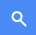
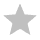
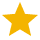
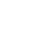
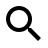
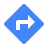
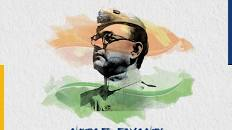

In [137]:
# Import the beautifulsoup 
# and request libraries of python. 
import requests 
import bs4 

# Make two strings with default google search URL 
# 'https://google.com/search?q=' and 
# our customized search keyword. 
# Concatenate them 
text= "imthyderabad"
url = 'https://google.com/search?q=' + text 

# Fetch the URL data using requests.get(url), 
# store it in a variable, request_result. 
request_result=requests.get( url ) 

# Creating soup from the fetched request 
soup = bs4.BeautifulSoup(request_result.text, "html.parser") 
print(soup) 


In [138]:
# soup.find.all( h3 ) to grab 
# all major headings of our search result, 
heading_object=soup.find_all( 'h3' ) 

# Iterate through the object 
# and print it as a string. 
for info in heading_object: 
    print(info.getText()) 
    print("------") 


IMT Hyderabad
------
IMT Hyderabad: Cut Off, Fees, Placements, Ranking, Admissions ...
------
Institute of Management Technology Hyderabad
------
IMT Hyderabad Courses & Fees 2021 - All PG Courses List - Shiksha
------
IMT Hyderabad - Home | Facebook
------
IMT Hyderabad - Posts | Facebook
------
IMT Hyderabad , Admissions 2021-22, Placements, Fees, Address
------


In [136]:
# import module 
import requests 
import bs4 

# Taking thecity name as an input from the user 
city = "Hyderabad"

# Generating the url 
url = "https://google.com/search?q=weather+in+" + city 

# Sending HTTP request 
request_result = requests.get( url ) 

# Pulling HTTP data from internet 
soup = bs4.BeautifulSoup( request_result.text , "html.parser" ) 

# Finding temperature in Celsius. 
# The temperature is stored inside the class "BNeawe". 
temp = soup.find( "div" , class_='BNeawe' ).text 
	
print( city +" "+ temp ) 


Hyderabad 23°C


In [139]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\HP\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [140]:
import time
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [144]:
data=[]

with Chrome(executable_path=r"C:\Users\HP\Downloads\chromedriver_win32\chromedriver.exe") as driver:
    wait = WebDriverWait(driver,15)
    driver.get("https://www.youtube.com/watch?v=kuhhT_cBtFU&t=2s")

    for item in range(50): 
        wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END)
        time.sleep(5)

    for comment in wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content"))):
        data.append(comment.text)

In [145]:
import pandas as pd   
df = pd.DataFrame(data, columns=['comment'])
df.head()

,comment
0,IN\nSKIP NAVIGATION\nSIGN IN\nUp Next\nRepubli...
1,Bodycam video released by the Atlanta Police D...
2,"""Between white officers and a black man"". I'm ..."
3,I always wonder why CNN never shows the whole ...
4,Good parenting: “teaches about good and bad pe...


In [146]:
df.shape

(182, 1)

In [147]:
df.to_csv('youtube.csv', index=False, encoding='utf-8')